# Intel DevCloud OpenVINO Pretrained Model 人臉偵測範例

DevCloud 自帶OpenVINO 2020.3.356(等於openvino-lts)及2021.3.394(等於openvino—2021)版, 操作時依選定環境自動切換。  
本範例須於2021.3.394版下執行。  

歐尼克斯實境互動工作室 OmniXRI Jack, 2021.6.5

In [1]:
!ls /opt/intel

intel_sdp_products.db  openvino_2020.3.356  openvino_fpga_2020.3.356
mediasdk	       openvino_2021	    openvino-lts
openvino	       openvino_2021.3.394


# 1.下載人臉偵測模型

可選用下列物件（人臉）偵測模型，更多可選用模型可參考 https://docs.openvinotoolkit.org/latest/object_detection_models_intel.html

    face-detection-adas-xxxx
    face-detection-retail-xxxx
    face-detection-xxxx

這裡選用 --name face-detection-retail-0005 （可自行變更所需模型名稱）

In [2]:
# 等價命令 !python3 /opt/intel/openvino_2021/deployment_tools/tools/model_downloader/downloader.py --name face-detection-retail-0005
!downloader.py --name face-detection-retail-0005

################|| Downloading face-detection-retail-0005 ||################

========== Downloading /home/u75102/My-Notebooks/intel/face-detection-retail-0005/FP32/face-detection-retail-0005.xml
... 100%, 162 KB, 397 KB/s, 0 seconds passed

========== Downloading /home/u75102/My-Notebooks/intel/face-detection-retail-0005/FP32/face-detection-retail-0005.bin
... 100%, 3987 KB, 3661 KB/s, 1 seconds passed

========== Downloading /home/u75102/My-Notebooks/intel/face-detection-retail-0005/FP16/face-detection-retail-0005.xml
... 100%, 161 KB, 390 KB/s, 0 seconds passed

========== Downloading /home/u75102/My-Notebooks/intel/face-detection-retail-0005/FP16/face-detection-retail-0005.bin
... 100%, 1993 KB, 2070 KB/s, 0 seconds passed

========== Downloading /home/u75102/My-Notebooks/intel/face-detection-retail-0005/FP16-INT8/face-detection-retail-0005.xml
... 100%, 431 KB, 630 KB/s, 0 seconds passed

========== Downloading /home/u75102/My-Notebooks/intel/face-detection-retail-0005/FP16-INT8/f

# 2.模型轉換

如果下載的是Intel Pretrained Model則不需轉換就自帶IR檔(xml,bin)
若是Public Pretrained Model則須進行轉換成IR檔，系統會自動判別。
--name 參數為待轉換模型名稱 

In [3]:
# 等價命令 !python3 /opt/intel/openvino_2021/deployment_tools/tools/model_downloader/converter.py --name face-detection-retail-0005
!converter.py --name face-detection-retail-0005
# 檢查模型轉檔後會產生/FP16, FP16-INT8, FP32不同精度的IR檔(xml, bin)
!ls intel/face-detection-retail-0005
!ls intel/face-detection-retail-0005/FP32

========== Skipping face-detection-retail-0005 (no conversions defined)

FP16  FP16-INT8  FP32
face-detection-retail-0005.bin	face-detection-retail-0005.xml


# 3.準備測試影像

從網路獲取任意一張測試影像並顯示

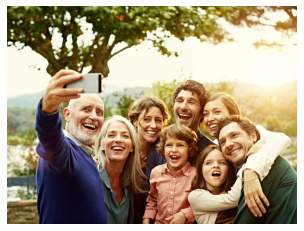

In [4]:
# 以OpenCV檢視輸入影像
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests


# 從網路獲取一張影像
file = requests.get("http://zahal-levy.com/wp-content/uploads/family-parents-grandparents-Morsa-Images-Taxi-56a906ad3df78cf772a2ef29.jpg")
# 將影像轉成OpenCV格式
img = cv2.imdecode(np.frombuffer(file.content, np.uint8), 1)
# 將img寫入磁碟命名為face.jpg
cv2.imwrite('face.jpg',img)

# 亦可直接讀取本地端影像
# img = cv2.imread('face.jpg')

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 將影像從BGR格式轉到RGB格式，才能讓plt.imshow()正確顯示
plt.figure() # 準備一顯示影像空間
plt.axis("off") # 設定關閉XY軸刻尺
plt.imshow(rgb) # 顯示影像

為更清楚了解物件偵測範例程式可支援的模型，可將models.lst及使用方式列出來確認。（此步驟可忽略）

In [5]:
# 列出可支援的模型名稱及對應的結構類型(architecture_type)
!cat /opt/intel/openvino_2021/deployment_tools/inference_engine/demos/object_detection_demo/python/models.lst

# This file can be used with the --list option of the model downloader.
# For --architecture_type=centernet
ctdet_coco_dlav0_384
ctdet_coco_dlav0_512
# For --architecture_type=ctpn
ctpn
# For --architecture_type=faceboxes
faceboxes-pytorch
# For --architecture_type=ssd
efficientdet-d0-tf
efficientdet-d1-tf
face-detection-????
face-detection-adas-????
face-detection-retail-????
faster-rcnn-resnet101-coco-sparse-60-0001
pedestrian-and-vehicle-detector-adas-????
pedestrian-detection-adas-????
pelee-coco
person-detection-????
person-detection-retail-0013
person-vehicle-bike-detection-????
product-detection-0001
retinanet-tf
rfcn-resnet101-coco-tf
ssd300
ssd512
ssd_mobilenet_v1_coco
ssd_mobilenet_v1_fpn_coco
ssd_mobilenet_v2_coco
ssd_resnet50_v1_fpn_coco
ssd-resnet34-1200-onnx
ssdlite_mobilenet_v2
vehicle-detection-????
vehicle-detection-adas-????
vehicle-license-plate-detection-barrier-????
# For --architecture_type=retinaface
retinaface-anti-cov
retinaface-resnet50
ssh-mxnet
# For --archi

# 4.進行推論

物件偵測範例程式 object_detection_demo.py  

輸入參數： 
-at 架構型式(architecture_type) 須參考models.lst指定方式，face-detection-retail-????須搭配ssd  
-i 輸入影像名稱 (*.png, *.jpg ...)  
-m 模型名稱 (*.xml) 
-o 輸出結果名稱 (*.png, *.jpg ...)  

最後顯示推論結果

[ INFO ] Initializing Inference Engine...
[ INFO ] Loading network...
[ INFO ] Reading network from IR...
[ INFO ] Use SingleOutputParser
[ INFO ] Loading network to CPU plugin...
[ INFO ] Starting inference...
To close the application, press 'CTRL+C' here or switch to the output window and press ESC key
OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 8 and format 'image2 / image2 sequence'
Unable to init server: Could not connect: Connection refused
Traceback (most recent call last):
  File "/opt/intel/openvino_2021/deployment_tools/inference_engine/demos/object_detection_demo/python/object_detection_demo.py", line 340, in <module>
    sys.exit(main() or 0)
  File "/opt/intel/openvino_2021/deployment_tools/inference_engine/demos/object_detection_demo/python/object_detection_demo.py", line 270, in main
    cv2.imshow('Detection Results', frame)
cv2.error: OpenCV(4.5.2-openvino) ../opencv/modules/highgui/src/window_gtk.cpp:624: error: (-2:Unspecified error) Can't in

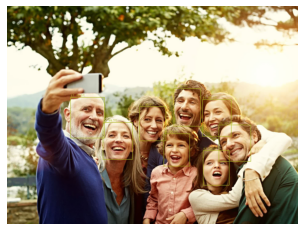

In [6]:
!python3 \
/opt/intel/openvino_2021/deployment_tools/inference_engine/demos/object_detection_demo/python/object_detection_demo.py -at ssd \
-i 'face.jpg' \
-m intel/face-detection-retail-0005/FP32/face-detection-retail-0005.xml \
-o 'output.jpg'

!ls ~/My-Notebooks/

out_img = cv2.imread('output.jpg') # 讀入欲顯示影像檔案
out_rgb = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB) # 將影像從BGR格式轉到RGB格式，才能讓plt.imshow()正確顯示
plt.figure() # 準備一顯示影像空間
plt.axis("off") # 設定關閉XY軸刻尺
plt.imshow(out_rgb) # 顯示影像